# Dataset dimentions
On this notebook we analize the downloaded videos before processing them.

### Method
Videos more than a minute and less than an hour were downloaded. All videos were re-coded to use the *h264* codec with a frame rate of 30FPS, while the audio used the *pcm_s16le* codec with a bitrate of 16k mono-channelled audio.

### Results
The downloaded videos amount to 8303 files, adding up to 121 days and 9:29:38 hours. Most videos have a duration around the 15 minute mark. The audio and video channels were separated and re-coded before face detection. Accounting for the video distribution by the frame dimensions (Fig. \[video_dist_area]) the 640x480 resolution is chosen as the upper threshold for resizing, as 75% of the videos lie above this threshold.

In [1]:
%matplotlib inline

from pathlib import Path
from datetime import timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
video_src = Path('../data/dataset_dimentions.csv')
column_types = [('video_id', str), ('width', int), ('height', int), ('duration', float)]
df = pd.read_csv(video_src, index_col=0, dtype=dict(column_types))

duration = df['duration'].sum()
print(f"Total length of footage: {timedelta(seconds=duration)} ({duration} seconds)")

Total length of footage: 121 days, 9:29:38.667000 (10488578.667 seconds)


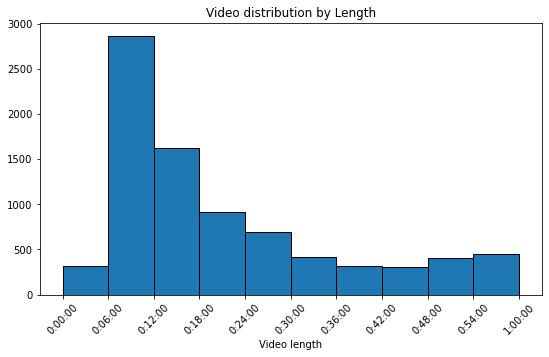

In [3]:
hist_range = (0, 3600)
height, bins = np.histogram(df['duration'].values, bins=10, range=hist_range)
widths = bins[1:] - bins[:-1]

fig = plt.figure(figsize=(9, 5))
plt.bar(bins[:-1], height, width=widths, edgecolor='black', align='edge')

plt.xlabel('Video length')
plt.xticks(bins, [str(timedelta(seconds=s))[:7] for s in bins], rotation=45)
plt.title('Video distribution by Length')
plt.savefig('images/video_dist_length.svg')
plt.savefig('images/video_dist_length.png', bbox_inches='tight')
plt.show()

**Figure \[video_dist_length]:** Distribution of the downloaded videos by their duration. Most videos last less than 30 minutes.

In [4]:
# Find the most frequent resolutions
df_area = df[['video_id', 'width', 'height']].groupby(['width', 'height']).count()
df_area.reset_index(inplace=True)
df_area.rename(columns = {'video_id':'count'}, inplace=True)
df_area['area'] = df_area['width'] * df_area['height']

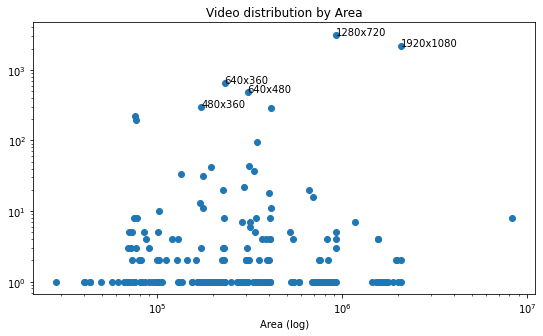

In [5]:
df_area.sort_values('count', ascending=False, inplace=True, ignore_index=True)

fig = plt.figure(figsize=(9, 5))

plt.scatter(df_area['area'], df_area['count'])

for width, height, count, area in df_area.iloc[:5, :].values:
    plt.text(area, count, f"{width}x{height}")

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Area (log)')
plt.title('Video distribution by Area')
plt.show()

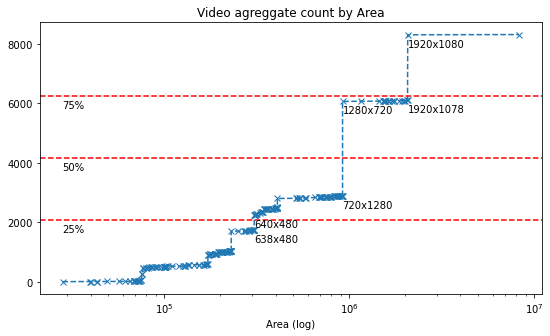

In [6]:
df_area.sort_values('area', ascending=True, inplace=True, ignore_index=True)

width, height, count, area = df_area.values.T
count = np.cumsum(count)
max_value = count.max()

fig = plt.figure(figsize=(9, 5))
plt.plot(area, count, linestyle='--', marker='x')
for p in [0.25, 0.5, 0.75]:
    pv = p * max_value
    i = np.argmax(count>pv)    
    plt.text(area[i] + 500, count[i] - 400, f"{width[i]}x{height[i]}")
    plt.text(area[i-1] + 500, count[i-1] - 400, f"{width[i-1]}x{height[i-1]}")
    
    plt.axhline(y=pv, color='r', linestyle='--')
    plt.text(area[0], pv - 400, f"{p:.0%}")

plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Area (log)')
plt.title('Video agreggate count by Area')
plt.savefig('images/video_dist_area.svg')
plt.savefig('images/video_dist_area.png', bbox_inches='tight')
plt.show()

**Figure \[video_dist_area]:** Aggregate count of all downloaded videos by the total area in pixels. The 25, 50 and 75 percent of total files plus the dimensions that correspond to the area value for which these boundaries are crossed are highlighted by the horizontal lines. Slightly more than 25% of the videos have a resolution smaller than 640x480.